In [5]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
data = pd.read_excel('220803_Final updated data.xlsx')
data.drop(['Ticker'], axis=1, inplace=True)
data.drop(data[data['Company']=='Company'].index.tolist(), inplace = True)
data = data[data['Years'] == 'CY2020']
data.reset_index( inplace = True, drop = True)
data.head(5)

,Company,Parameters,Years,Value,Unit
0,Walmart Inc.,Avg. Cash Conversion Cycle,CY2020,1.30955,Days
1,Walmart Inc.,Cash from Financing,CY2020,-16117,"USD,Mn"
2,Walmart Inc.,Cash from Investing,CY2020,-10071,"USD,Mn"
3,Walmart Inc.,Cash from Operations,CY2020,36074,"USD,Mn"
4,Walmart Inc.,Cost of Goods Sold,CY2020,0.751702,Ratio


In [6]:
data = data.pivot_table(index=['Company','Years'], columns='Parameters', values='Value',aggfunc='first')
data.reset_index(inplace=True)
data.shape

(1434, 31)

In [7]:
#dropping columns which has high percentage of NaN values
percent_missing = data.isnull().sum() * 100 / len(data)
drop_cols = []
percent_missing = percent_missing.to_dict()
print(percent_missing)
#60 percent values 
for name, val in percent_missing.items():
    if val > 60:
        drop_cols.append(name)
data.drop(drop_cols, axis=1, inplace=True)
#dropping Net Debt/(EBITDA-Capex) more than 35% data contains NM
data.drop(['Net Debt/(EBITDA-Capex)'], axis=1, inplace=True)

{'Company': 0.0, 'Years': 0.0, 'Asia Pacific': 96.37377963737796, 'Avg. Cash Conversion Cycle': 5.299860529986053, 'Cash from Financing': 5.299860529986053, 'Cash from Investing': 5.299860529986053, 'Cash from Operations': 5.299860529986053, 'Cat Food': 96.86192468619247, 'China': 99.3723849372385, 'Cost of Goods Sold': 7.391910739191074, 'Current Ratio': 5.299860529986053, 'Dog Food': 96.23430962343096, 'Eastern Europe': 99.09344490934448, 'Latin America': 99.09344490934448, 'Middle East and Africa': 98.67503486750348, 'Net Debt/(EBITDA-Capex)': 5.299860529986053, 'Net Income to the Company': 7.391910739191074, 'North America': 99.23291492329149, 'Operating Expenses': 7.391910739191074, 'Operating Income': 7.391910739191074, 'Other Pet Food': 98.25662482566248, 'Payout Ratio': 5.299860529986053, 'R&D Expense': 7.391910739191074, 'Return on Capital': 5.299860529986053, 'Selling General & Admin. Expenses': 7.391910739191074, 'Total Assets': 5.299860529986053, 'Total Assets turnover': 5.

In [8]:
#Some columns as null value same other columns
data = data.dropna(how = "all", subset= ['Avg. Cash Conversion Cycle', 'Cash from Financing','Cash from Investing', 'Cash from Operations', 'Cost of Goods Sold',
       'Current Ratio', 'Net Income to the Company', 'Operating Expenses','Operating Income', 'Payout Ratio', 'R&D Expense', 'Return on Capital',
       'Selling General & Admin. Expenses', 'Total Assets','Total Assets turnover', 'Total Debt', 'Total Debt/Capital','Total Revenue'])
#remove rows only if 6 columns value value as null
data = data[data.isnull().sum(axis=1) < 6]

In [9]:
data.shape

(1328, 20)

In [95]:
for col in data.columns:
    data[col] = data[col].astype('str')
    data = data[data[col].str.contains("(Invalid Identifier)") == False]
#Payout Ratio contains 78 records as NM replacing with majority value 0
data['Payout Ratio'] = data['Payout Ratio'].replace('NM', 0)

for col in data.columns[2:]:
    data[col] = data[col].astype('float')
    
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
vif_data = pd.DataFrame()
df = data.iloc[:,2:]
vif_data["feature"] = df.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
drop_col = []
for ind in vif_data.index:
    if vif_data['VIF'][ind] > 5:
        drop_col.append(vif_data['feature'][ind])
data.drop(drop_col, axis=1, inplace=True)

In [96]:
pca_df = data.iloc[:,2:]

In [97]:
pca_df

Parameters,Avg. Cash Conversion Cycle,Current Ratio,Payout Ratio,Return on Capital,Total Assets turnover,Total Debt/Capital,Total Revenue
0,1.04639,1.76270,0.0000,-22.3878,3.53830,19.8404,1256.49557
1,0.00000,0.62730,88.8732,7.0762,1.46813,88.1159,631.78760
2,95.23069,2.24494,0.0000,9.2695,0.75667,2.3057,310.15590
3,100.11344,1.54330,34.2930,9.3885,1.23610,31.1120,3401.30918
4,90.32843,1.33820,0.0000,1.3409,1.83625,49.0127,997.52049
...,...,...,...,...,...,...,...
1429,26.37250,3.44236,0.0000,-8.7606,1.30114,49.7565,1669.31902
1430,0.00000,0.00000,0.0000,3.2994,0.00000,20.6925,239.47903
1431,19.57551,1.52050,0.0000,0.4079,0.78755,29.7044,193.40195
1432,195.10765,2.40385,0.0000,1.9045,0.64056,36.4182,300.15100


In [98]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(pca_df)
scaled_data = pd.DataFrame(scaled_df,columns = data.columns[2:])

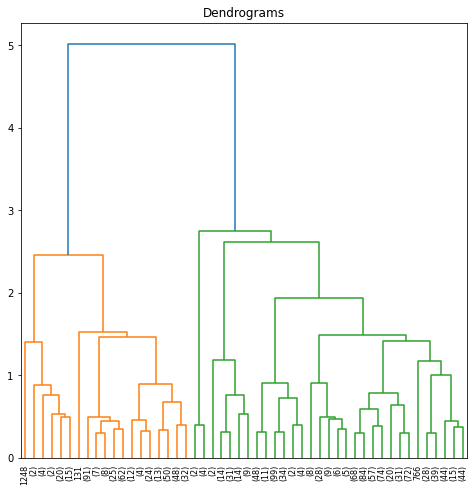

In [99]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(scaled_data, method='ward'),truncate_mode='lastp',p=50)

In [100]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from scipy.spatial.distance import cdist
from sklearn import metrics
model = AgglomerativeClustering(n_clusters = 4).fit(scaled_data)
ypredict = model.fit_predict(scaled_data)

clf = NearestCentroid()
clf.fit(scaled_data, ypredict)
dists = cdist(scaled_data,clf.centroids_,metric='euclidean')
Hierarchical_Distance_Matrix = pd.DataFrame(dists,columns=['Hierarchical_Dist_'+str(i) for i in range(4)])
print(metrics.silhouette_score(scaled_data, ypredict,metric='euclidean'))
print(metrics.davies_bouldin_score(scaled_data, ypredict))
print(metrics.calinski_harabasz_score(scaled_data, ypredict))

0.3635998296671322
0.7783614824766051
429.6493192688808


In [101]:
#4
0.3635998296671322
0.7783614824766051
429.6493192688808

#5
0.34518340408794645
0.7965991596332713
435.9434839766723

#6
0.2468091255892582
0.9562656919579999
422.4567522025369

#8
0.2580714395778678
0.872699284596683
384.8452370843073

#10
0.2036981942271305
1.0356604696734881
381.28127515173685

381.28127515173685

inside pyplot file


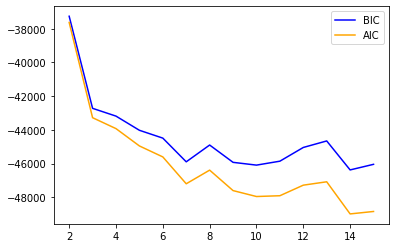

In [102]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.pyplot as plt

# b=PCA_components.values.reshape(-1,1)
# b=np.log(b)
####### finding best n_components ########
k= np.arange(2,16,1)
# GMM(2,covariance_type='full').fit(b)
clfs= [GMM(n,covariance_type='full').fit(scaled_data) for n in k]
aics= [clf.aic(scaled_data) for clf in clfs]
bics= [clf.bic(scaled_data) for clf in clfs]
plt.plot(k,bics,color='b',label='BIC')
plt.plot(k,aics,color='orange',label='AIC')
# plt.xticks(list(range(3,20,1)))
plt.legend()
plt.show()

In [103]:
from sklearn.mixture import GaussianMixture
model = GaussianMixture(n_components=3, init_params='kmeans',n_init=50, random_state=1 # for reproducibility
                        )
labels = model.fit_predict(scaled_data)   
# from collections import defaultdict
# counter = defaultdict(int)
# for letter in labels:
#     counter[letter] += 1
# counter
yprobs = model.predict_proba(scaled_data)
GMM_Probabilities = pd.DataFrame(yprobs,columns=['GMM_Prob_'+str(i) for i in range(3)])
print(metrics.silhouette_score(scaled_data, labels,metric='euclidean'))
print(metrics.davies_bouldin_score(scaled_data, labels))
print(metrics.calinski_harabasz_score(scaled_data, labels))

0.16584127916091868
2.7220517232267785
80.73202114391535


In [104]:
#3
0.16584127916091868
2.7220517232267785
80.73202114391535
#4
0.07813605805047437
2.7803045518294742
74.92247959959083

#5
0.008401257149047629
3.970682399403942
73.54446982590946


#8
-0.025575515477388903
3.0603404926188045
66.4621631608017

#10
-0.012790556670992206
2.2705188985768148
84.20365637062294

84.20365637062294

In [105]:
from fcmeans import FCM

model = FCM(n_clusters=4, m=1.25)
model.fit(scaled_data.values)

centers = model.centers
labels = model.predict(scaled_data.values)
yprobs = model.soft_predict(scaled_data.values)

FCM_Probabilities = pd.DataFrame(yprobs,columns=['FCM_Prob_'+str(i) for i in range(4)])

print(metrics.silhouette_score(scaled_data, labels,metric='euclidean'))
print(metrics.davies_bouldin_score(scaled_data, labels))
print(metrics.calinski_harabasz_score(scaled_data, labels))

0.2859569695852424
1.0885786375259427
452.6561107591157


In [106]:
#4
0.2859569695852424
1.0885786375259427
452.6561107591157

#6
0.2559651495796668
1.1824039567469713
360.42499740867254

#8
0.250959280920358
1.0546901324698224
439.67447060288424

#10
0.20366551128057947
1.3940936795198478
256.09489592946727

256.09489592946727

In [107]:
new_data = pd.concat([Hierarchical_Distance_Matrix,GMM_Probabilities,FCM_Probabilities],axis=1)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(new_data)
new_scaled_data = pd.DataFrame(scaled_df,columns = new_data.columns)

For n_clusters = 2 The average silhouette_score is : 0.3685008091731365
For n_clusters = 3 The average silhouette_score is : 0.45261953704400193
For n_clusters = 4 The average silhouette_score is : 0.5125311264788166
For n_clusters = 5 The average silhouette_score is : 0.6127332053498515
For n_clusters = 6 The average silhouette_score is : 0.6665263014707677
For n_clusters = 7 The average silhouette_score is : 0.6890411613208427
For n_clusters = 8 The average silhouette_score is : 0.7127373794011435
For n_clusters = 9 The average silhouette_score is : 0.7329807078032704
For n_clusters = 10 The average silhouette_score is : 0.7392512920914283
For n_clusters = 11 The average silhouette_score is : 0.6926915756795592
For n_clusters = 12 The average silhouette_score is : 0.7016757962405624
For n_clusters = 13 The average silhouette_score is : 0.7035340600113084
For n_clusters = 14 The average silhouette_score is : 0.7017615734089402
For n_clusters = 15 The average silhouette_score is : 0.69

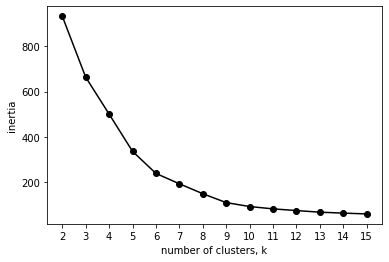

In [108]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.style as style

range_n_clusters = list(range(2,16))
silhouette_avg_n_clusters = []
inertias = []

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0,init='k-means++')
    cluster_labels = clusterer.fit_predict(new_scaled_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(new_scaled_data, cluster_labels)
    inertias.append(clusterer.inertia_)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
plt.plot(range_n_clusters, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(range_n_clusters)
plt.show()

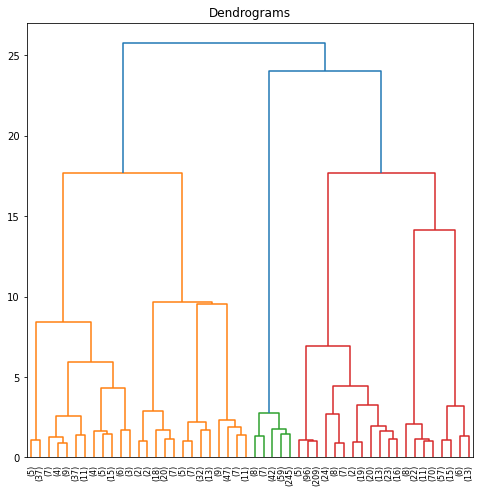

In [109]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(8, 8))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(new_scaled_data, method='ward'),truncate_mode='lastp',p=50)

inside pyplot file


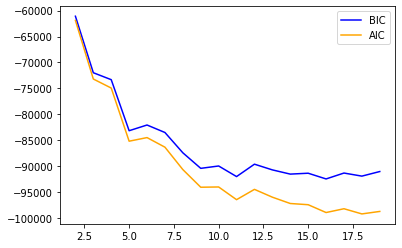

In [110]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.pyplot as plt

# b=PCA_components.values.reshape(-1,1)
# b=np.log(b)
####### finding best n_components ########
k= np.arange(2,20,1)
# GMM(2,covariance_type='full').fit(b)
clfs= [GMM(n,covariance_type='full').fit(new_scaled_data) for n in k]
aics= [clf.aic(new_scaled_data) for clf in clfs]
bics= [clf.bic(new_scaled_data) for clf in clfs]
plt.plot(k,bics,color='b',label='BIC')
plt.plot(k,aics,color='orange',label='AIC')
# plt.xticks(list(range(3,20,1)))
plt.legend()
plt.show()

In [223]:
from fcmeans import FCM
from sklearn import metrics
model = FCM(n_clusters=6,m=1.25)
model.fit(new_scaled_data.values)
centers = model.centers
labels = model.predict(new_scaled_data.values)
print(metrics.silhouette_score(new_scaled_data, labels,metric='euclidean'))
print(metrics.davies_bouldin_score(new_scaled_data, labels))
print(metrics.calinski_harabasz_score(new_scaled_data, labels))

0.666634724437188
0.7512932680267933
1178.4346407373905


inside pyplot file


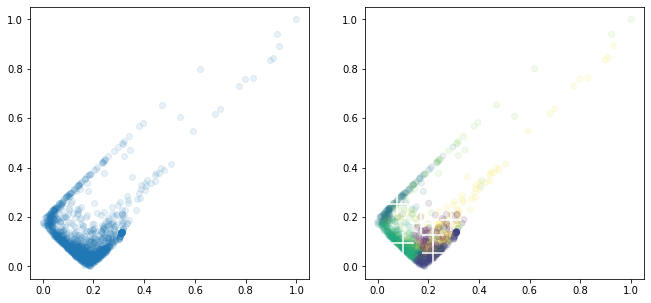

In [224]:
# plot result
f, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].scatter(new_scaled_data.iloc[:,0], new_scaled_data.iloc[:,1], alpha=.1)
axes[1].scatter(new_scaled_data.iloc[:,0], new_scaled_data.iloc[:,1], c=labels, alpha=.1)
axes[1].scatter(centers[:,0], centers[:,1], marker="+", s=500, c='w')
plt.show()

In [225]:
#4
0.47654196586080355
1.2675767041759798
547.6395505818418
#5

0.5409684471658146
0.9643119379658213
663.1616595687274
#6
0.5858365669790282
0.9853102002938402
739.1714062060238
#7
0.6137540534388438
0.8482520972125405
784.6926743053193
#8
0.6465345881518043
0.7568238396198254
880.6311628854606

#10
0.6982215491191565
0.6609118494773962
1205.7322817304228

1205.7322817304228

In [226]:
from collections import defaultdict
counter = defaultdict(int)
for letter in labels:
    counter[letter] += 1
dict(counter)
data['Cluster_Ids'] = labels

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(scaled_data, data.iloc[:,-1], test_size=0.20, random_state = 0, stratify=data.iloc[:,-1].values)

In [227]:
from collections import defaultdict
counter = defaultdict(int)
for letter in labels:
    counter[letter] += 1
dict(counter)

{4: 170, 3: 400, 1: 390, 2: 127, 5: 140, 0: 101}

In [130]:
pd.value_counts(ytrain)

2    317
4    308
0    111
6    102
3     97
5     80
1     47
Name: Cluster_Ids, dtype: int64

In [482]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
dtc = DecisionTreeClassifier()
grid = { 
    'criterion': {'gini', 'entropy', 'log_loss'},
    'max_features': ['sqrt', 'log2','auto'],
    'max_depth' : list(range(5,11)),
    'min_samples_split': list(range(4,11)),
    'min_samples_leaf': list(range(4,11)),
    'criterion' :['gini', 'entropy'],
    'max_leaf_nodes': list(range(5,18)),
    'random_state' : [0]
}
dtc_cv = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = grid, cv = 8)
dtc_cv.fit(xtrain, ytrain)
dtc_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 'sqrt',
 'max_leaf_nodes': 17,
 'min_samples_leaf': 6,
 'min_samples_split': 4,
 'random_state': 0}

              precision    recall  f1-score   support

           0       0.89      0.96      0.92        25
           1       0.89      0.71      0.79        24
           2       0.91      0.83      0.87        12
           3       0.84      0.95      0.89        77
           4       0.71      0.36      0.48        28
           5       0.84      0.94      0.89        80
           6       0.47      0.45      0.46        20

    accuracy                           0.82       266
   macro avg       0.79      0.74      0.76       266
weighted avg       0.81      0.82      0.81       266

F1 Score:  0.806794173245624
ROC AUC Score:  0.9492340882176525


,0,1,2,3,4,5,6
0,24,0,0,0,0,1,0
1,3,17,0,0,0,4,0
2,0,0,10,2,0,0,0
3,0,0,1,73,2,0,1
4,0,1,0,8,10,0,9
5,0,1,0,2,2,75,0
6,0,0,0,2,0,9,9


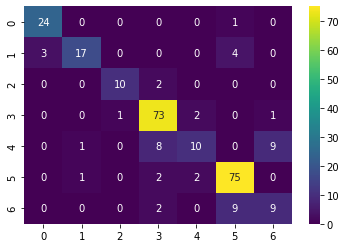

In [60]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion= 'entropy',max_depth = 9,max_features = 'sqrt',
max_leaf_nodes = 16,min_samples_leaf = 6,min_samples_split = 4,random_state= 0
                             )
dtc.fit(xtrain,ytrain)
ypredict = dtc.predict(xtest)

from sklearn.metrics import classification_report,confusion_matrix,f1_score,roc_auc_score
import seaborn as sns
print(classification_report(ytest,ypredict))
print("F1 Score: ",f1_score(ytest,ypredict,average='weighted'))
# Generate class membership probabilities
y_preb_probs = dtc.predict_proba(xtest)

print('ROC AUC Score: ',roc_auc_score(ytest, y_preb_probs, average="weighted", multi_class="ovr"))

sns.heatmap(confusion_matrix(ytest,ypredict),cmap='viridis',annot=True)
pd.DataFrame(confusion_matrix(ytest,ypredict))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       102
           1       0.93      0.72      0.81        97
           2       0.73      0.87      0.80        47
           3       0.88      0.97      0.93       308
           4       0.79      0.33      0.47       111
           5       0.92      0.99      0.95       317
           6       0.60      0.62      0.61        80

    accuracy                           0.86      1062
   macro avg       0.81      0.79      0.78      1062
weighted avg       0.86      0.86      0.84      1062

F1 Score:  0.844621447273309
ROC AUC Score:  0.9729515323012814


<AxesSubplot:>

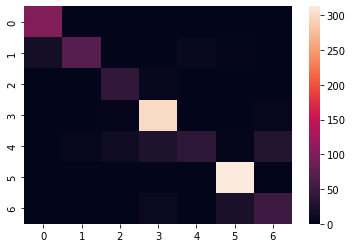

In [61]:
ypredict = dtc.predict(xtrain)
from sklearn.metrics import classification_report,confusion_matrix,f1_score,roc_auc_score
import seaborn as sns
print(classification_report(ytrain,ypredict))
print("F1 Score: ",f1_score(ytrain,ypredict,average='weighted'))
# Generate class membership probabilities
y_preb_probs = dtc.predict_proba(xtrain)

print('ROC AUC Score: ',roc_auc_score(ytrain, y_preb_probs, average="weighted", multi_class="ovr"))

sns.heatmap(confusion_matrix(ytrain,ypredict))

In [62]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection, metrics
from sklearn.model_selection import GridSearchCV

# #Grid seach on subsample and max_features
# param_test2 =  { 
#     'max_features': ['sqrt', 'log2','auto'],
#     'max_depth' : list(range(5,10)),
#     'min_samples_split': list(range(4,10)),
#     'min_samples_leaf': list(range(4,10)),
#     'max_leaf_nodes': list(range(5,10)),
#     'n_estimators':range(10,200,50),
#     'learning_rate' :[0.01,0.05, 0.1],
#     'random_state' : [0]
# }
# #xtrain, xtest, ytrain, ytest
# gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(),param_grid = param_test2, cv = 4)
# gsearch2.fit(xtrain,ytrain)
# gsearch2.best_params_

In [63]:
from sklearn.metrics import accuracy_score
gbm = GradientBoostingClassifier(learning_rate=0.05, n_estimators=50,max_depth=4, min_samples_split=20, 
                                min_samples_leaf=6, subsample=0.85, random_state=0)
gbm.fit(xtrain,ytrain)
ypredict = gbm.predict(xtest)
print(classification_report(ytest,ypredict))
print(accuracy_score(ytest,ypredict))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92        25
           1       0.86      0.79      0.83        24
           2       0.92      0.92      0.92        12
           3       0.94      0.99      0.96        77
           4       0.89      0.86      0.87        28
           5       0.93      0.96      0.94        80
           6       0.94      0.85      0.89        20

    accuracy                           0.92       266
   macro avg       0.92      0.89      0.90       266
weighted avg       0.92      0.92      0.92       266

0.924812030075188


In [64]:
ypredict = dtc.predict(xtrain)
print(classification_report(ytrain,ypredict))
print(accuracy_score(ytrain,ypredict))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       102
           1       0.93      0.72      0.81        97
           2       0.73      0.87      0.80        47
           3       0.88      0.97      0.93       308
           4       0.79      0.33      0.47       111
           5       0.92      0.99      0.95       317
           6       0.60      0.62      0.61        80

    accuracy                           0.86      1062
   macro avg       0.81      0.79      0.78      1062
weighted avg       0.86      0.86      0.84      1062

0.8587570621468926


In [73]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Bar(
    x=[1, 2, 3, 5.5, 10],
    y=[10, 8, 6, 4, 2],
    width=[0.8, 0.8, 0.8, 3.5, 4] # customize width here
)])
print(fig)
fig.show()

Figure({
    'data': [{'type': 'bar', 'width': [0.8, 0.8, 0.8, 3.5, 4], 'x': [1, 2, 3, 5.5, 10], 'y': [10, 8, 6, 4, 2]}],
    'layout': {'template': '...'}
})


In [81]:
import plotly.graph_objects as go
import numpy as np

labels = ['A', 'B', 'C']
widths = np.array([0.5]*3)
widths[1] = 0.5*4
print(widths)
fig = go.Figure(data=[go.Bar(x=np.cumsum(widths)-widths,  y = [2, 4, 1])])
fig.update_layout(paper_bgcolor = 'rgba(0,0,0,0)',plot_bgcolor = 'rgba(0,0,0,0)')
fig.update_xaxes( 
    showline = True, linecolor = '#000',
    tickvals=np.cumsum(widths)-widths/2, 
    ticktext= ["%s" % (l) for l, w in zip(labels, widths)]
)
fig.update_yaxes( 
    showline = True, linecolor = '#000')
fig.update_layout()
print(fig)
fig.show()

[0.5 2.  0.5]
Figure({
    'data': [{'type': 'bar', 'x': array([0. , 0.5, 2.5]), 'y': [2, 4, 1]}],
    'layout': {'paper_bgcolor': 'rgba(0,0,0,0)',
               'plot_bgcolor': 'rgba(0,0,0,0)',
               'template': '...',
               'xaxis': {'linecolor': '#000',
                         'showline': True,
                         'ticktext': [A, B, C],
                         'tickvals': array([0.25, 1.5 , 2.75])},
               'yaxis': {'linecolor': '#000', 'showline': True}}
})


In [89]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    name='Group 1',
    x=[0], y=[3],
    width = 0.8,
    marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6
))

fig.add_trace(go.Bar(
    name='Group 1',
    x=[0], y=[6],
    width = 0.8,
    marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6
))

fig.add_trace(go.Bar(
    name='Group 2',
    x=[1], y=[6 ],
    width = 0.4,
    marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6
))
fig.add_trace(go.Bar(
    name='Group 1',
    x=[1 ], y=[4],
    width = 0.4,
    marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6
))

fig.update_layout(barmode='stack')
print(fig)
fig.show()

Figure({
    'data': [{'marker': {'color': 'rgb(158,202,225)', 'line': {'color': 'rgb(8,48,107)', 'width': 1.5}},
              'name': 'Group 1',
              'opacity': 0.6,
              'type': 'bar',
              'width': 0.8,
              'x': [0],
              'y': [3]},
             {'marker': {'color': 'rgb(158,202,225)', 'line': {'color': 'rgb(8,48,107)', 'width': 1.5}},
              'name': 'Group 1',
              'opacity': 0.6,
              'type': 'bar',
              'width': 0.8,
              'x': [0],
              'y': [6]},
             {'marker': {'color': 'rgb(158,202,225)', 'line': {'color': 'rgb(8,48,107)', 'width': 1.5}},
              'name': 'Group 2',
              'opacity': 0.6,
              'type': 'bar',
              'width': 0.4,
              'x': [1],
              'y': [6]},
             {'marker': {'color': 'rgb(158,202,225)', 'line': {'color': 'rgb(8,48,107)', 'width': 1.5}},
              'name': 'Group 1',
              'opacity': 0.6,
 